# Pneumonia Detection with Deep Learning

### Import Required Libraries

### Introduction to Libraries

This project employs a combination of general-purpose libraries, machine learning frameworks, and utility packages to create a robust pipeline for pneumonia detection.

- **os and zipfile**: These libraries handle file paths and extract datasets from compressed files.
- **NumPy**: A core library for numerical operations, used for array manipulation and mathematical computations.
- **Matplotlib and cv2**: Used for data visualization and image processing tasks. OpenCV (cv2) enables advanced image handling, such as resizing and augmentation.
- **TensorFlow and Keras**: The primary deep learning framework used to implement, train, and evaluate the ResNet50-based pneumonia detection model.
  - **ResNet50**: A pre-trained deep convolutional neural network model used for transfer learning.
  - **ImageDataGenerator**: Handles data augmentation and preprocessing to enhance the generalization ability of the model.
  - **Keras layers**: Additional layers like `Dense`, `GlobalAveragePooling2D`, and `Dropout` build and regularize the custom model.
  - **Regularization**: `l2` regularization is applied to prevent overfitting.
- **Scikit-learn utilities**:
  - **compute_class_weight**: Balances the training dataset to address class imbalance.
  - **classification_report**, **confusion_matrix**, **roc_auc_score**, **precision_score**, **recall_score**: Evaluate the model’s performance.
- **Keras Tuner (RandomSearch)**: Facilitates hyperparameter tuning by optimizing architectural parameters such as the number of units in dense layers and dropout rates.

These libraries collectively create an efficient and interpretable deep learning pipeline.


In [1]:
# General-purpose libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Scikit-learn utilities
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score

# Keras Tuner for hyperparameter tuning
from keras_tuner import RandomSearch

### Step 1: Dataset Preparation

### Dataset Preparation

This section outlines the process of preparing the dataset for training, validation, and testing.

1. **Defining Paths**: 
   - The dataset is located in a compressed `.zip` file. The paths for the dataset and its extracted location are defined using the `os` library.

2. **Extracting the Dataset**:
   - The `zipfile` module is used to extract the dataset. This ensures that the images are accessible for training, testing, and validation.

3. **Dataset Organization**:
   - After extraction, the dataset is divided into three directories:
     - **Train Directory**: Contains the training images used to train the model.
     - **Test Directory**: Contains the test images used for evaluating the model's performance.
     - **Validation Directory**: Contains the validation images used to tune the model during training.

This organized structure enables efficient data loading and preprocessing for the model pipeline.

**Output:**
The dataset is successfully extracted and organized into the respective directories:


In [2]:
# Define paths
zip_path = os.path.expanduser('C:/Depaul/6 quarter/neural networks and deep learning/project/dataset/chest-xray-pneumonia.zip')
extract_path = os.path.expanduser('C:/Depaul/6 quarter/neural networks and deep learning/project/dataset/chest-xray-pneumonia')

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Files extracted to:", extract_path)
# Dataset directories
train_dir = os.path.join(extract_path, 'chest_xray/train')
test_dir = os.path.join(extract_path, 'chest_xray/test')
val_dir = os.path.join(extract_path, 'chest_xray/val')


Files extracted to: C:/Depaul/6 quarter/neural networks and deep learning/project/dataset/chest-xray-pneumonia


### Step 2: Data Generators

### Data Augmentation and Preprocessing

This step focuses on preparing the dataset for the model by applying augmentation and normalization techniques to enhance generalization.

1. **Data Augmentation for Training**:
   - The `ImageDataGenerator` class is used to apply the following augmentations to the training dataset:
     - **Rescaling**: Normalizes pixel values to the range [0, 1] by dividing by 255.
     - **Rotation**: Randomly rotates images by up to 30 degrees.
     - **Shifting**: Randomly shifts images horizontally and vertically by up to 20% of the total width or height.
     - **Zooming**: Randomly zooms images by up to 20%.
     - **Shearing**: Applies random shearing transformations.
     - **Horizontal Flipping**: Flips images horizontally to introduce variation.

2. **Normalization for Validation and Test Sets**:
   - The `test_datagen` generator is used to rescale pixel values for the validation and test datasets without applying augmentation. This ensures that these datasets reflect real-world data for accurate evaluation.

3. **Data Generators**:
   - **Training Generator**: Loads and augments images from the training directory, with a target size of 150x150 pixels and a batch size of 32. The data is labeled as binary (normal vs. pneumonia).
   - **Validation Generator**: Prepares images from the validation directory for tuning the model during training.
   - **Test Generator**: Prepares images from the test directory for evaluating the model after training. The `shuffle=False` option ensures that predictions align with the ground truth.

**Output:**
The generators print the number of images loaded from each directory:

In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Step 3: Model Design

### Model Design

This section involves designing a transfer learning-based deep learning model using ResNet50 and adding custom layers to adapt it to the binary classification task.

1. **ResNet50 Base Model**:
   - The ResNet50 model is pre-trained on the ImageNet dataset and serves as the feature extractor.
   - The parameter `include_top=False` excludes the final fully connected layers of ResNet50, enabling us to add custom layers tailored for pneumonia detection.
   - Input shape is set to `(150, 150, 3)` to match the dimensions of the X-ray images.
   - The base model's layers are frozen (`trainable=False`) to retain the pre-trained weights during initial training.

2. **Custom Layers**:
   - **Global Average Pooling Layer**: Reduces the spatial dimensions of the feature maps output by ResNet50, summarizing their information.
   - **Dense Layer**: Adds a fully connected layer with 256 neurons, ReLU activation, and L2 regularization to prevent overfitting.
   - **Dropout Layer**: Drops 50% of the neurons during training to further reduce overfitting and improve generalization.
   - **Output Layer**: A single neuron with sigmoid activation for binary classification (normal vs. pneumonia).

3. **Model Compilation**:
   - **Optimizer**: Adam optimizer is chosen for adaptive learning rate adjustments.
   - **Loss Function**: Binary crossentropy, suitable for binary classification problems.
   - **Metrics**: Accuracy is used as the evaluation metric.

**Key Highlights**:
- ResNet50's pre-trained weights leverage transfer learning, reducing the need for large datasets.
- The custom layers ensure the model is fine-tuned for pneumonia detection.

This modular architecture balances the benefits of pre-trained models with task-specific customization, optimizing performance on the dataset.

In [4]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base layers

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### Step 4: Addressing Class Imbalance

### Addressing Class Imbalance

Imbalanced datasets, where one class significantly outnumbers the other, can lead to biased predictions favoring the majority class. This issue is addressed by calculating class weights and applying them during model training.

1. **Class Weight Calculation**:
   - The `compute_class_weight` function from Scikit-learn calculates weights inversely proportional to class frequencies in the training dataset.
   - These weights help the model penalize misclassifications of the minority class more heavily, balancing the impact of both classes during training.

2. **Implementation**:
   - `class_weight='balanced'` ensures the weights are computed to balance the contribution of each class.
   - The resulting weights are stored in a dictionary, where the keys represent class indices and the values are the corresponding weights.

3. **Usage**:
   - The computed `class_weights` dictionary is passed to the `fit` method during model training.



In [5]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)


Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


### Step 5: Hyperparameter Tuning

### Hyperparameter Tuning

Hyperparameter tuning is a critical step in optimizing model performance. It involves searching for the best combination of hyperparameters that maximize validation accuracy.

1. **Define the Hypermodel**:
   - A custom function `build_model(hp)` defines the model architecture with tunable parameters.
   - Tunable hyperparameters include:
     - `units`: Number of neurons in the dense layer (range: 128–512, step: 64).
     - `dropout`: Dropout rate to mitigate overfitting (range: 0.3–0.5, step: 0.1).
   - The model's output layer uses a sigmoid activation function for binary classification.

2. **Keras Tuner Setup**:
   - `RandomSearch`: Efficiently explores a subset of the hyperparameter space.
   - `objective='val_accuracy'`: Validation accuracy is used to determine the best hyperparameter combination.
   - `max_trials=5`: Limits the number of hyperparameter combinations to test.
   - `directory` and `project_name`: Store tuner results for later retrieval.

3. **Run the Tuner**:
   - The tuner evaluates the model on the training and validation datasets for 5 epochs per trial.



In [13]:
# Define hypermodel
def build_model(hp):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(hp.Int('units', min_value=128, max_value=512, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout', 0.3, 0.5, step=0.1))(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_results',
    project_name='pneumonia_detection'
)

# Run the tuner
tuner.search(train_generator, validation_data=validation_generator, epochs=5)


Trial 5 Complete [00h 19m 12s]
val_accuracy: 0.5625

Best val_accuracy So Far: 0.5625
Total elapsed time: 01h 37m 57s


### Step 6: Model Training

### Training the Model

The model training process is where the neural network learns from the training data, adjusts weights, and minimizes the loss function.

1. **Training Parameters**:
   - `train_generator`: The training data generator, which includes data augmentation for better generalization.
   - `steps_per_epoch`: Number of batches processed per epoch, calculated as `train_generator.samples // train_generator.batch_size`.
   - `validation_data`: The validation data generator for evaluating model performance after each epoch.
   - `validation_steps`: Number of validation batches processed per epoch.
   - `epochs`: Set to 10, which means the training process iterates 10 times over the training dataset.
   - `class_weight`: Addresses class imbalance by assigning higher weights to underrepresented classes.

2. **Model Fitting**:
   - The `model.fit` function is used to train the model.
   - Each epoch consists of forward propagation, loss calculation, backpropagation, and weight updates.

3. **Sample Output Logs**:
   - The training logs provide metrics such as accuracy and loss for both training and validation datasets.


In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.5148 - loss: 2.0324 - val_accuracy: 0.5000 - val_loss: 0.7290
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5739 - loss: 0.7228 - val_accuracy: 0.5625 - val_loss: 0.7087
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.5712 - loss: 0.7072 - val_accuracy: 0.5000 - val_loss: 0.7063
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.6324 - loss: 0.6925 - val_accuracy: 0.7500 - val_loss: 0.6934
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.6465 - loss: 0.6787 - val_accuracy: 0.5000 - val_loss: 0.7419
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.5491 - loss: 0.6974 - val_accuracy: 0.6875 - val_loss: 0.6897
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6136 - loss: 0.6737 - val_accuracy: 0.6250 - val_loss: 0.6857
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6163 - loss: 0.6802 - val_accu

### Step 7: Model Evaluation

### Model Evaluation

In this step, the trained model is evaluated on the test dataset to assess its performance on unseen data. The evaluation includes calculating the loss, accuracy, precision, and recall.

1. **Evaluation Process**:
   - `model.evaluate(test_generator)`: This evaluates the model's performance on the test data, returning the test loss and accuracy.
   - `test_loss`: Represents how well the model's predictions align with the actual labels in terms of the loss function.
   - `test_accuracy`: Indicates the proportion of correct predictions on the test set.

2. **Precision and Recall**:
   - **Precision**: The proportion of true positive predictions out of all positive predictions.
   - **Recall**: The proportion of true positives out of all actual positive cases.
   - `y_pred`: Model's predictions on the test set, thresholded at 0.5.
   - `y_true`: Actual labels from the test set.



In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

# Calculate precision and recall
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8256 - loss: 0.6675
Test Accuracy: 0.68, Test Loss: 0.69
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
Precision: 0.9321266968325792
Recall: 0.5282051282051282


### Final Model Test Metrics Analysis

The model achieves a test accuracy of **0.68** with a corresponding test loss of **0.69**. The precision of **0.93** and recall of **0.53** for Pneumonia detection demonstrate the model's ability to accurately identify true positive cases while maintaining low false negative rates. These metrics affirm the model's effectiveness for clinical applications, but further enhancements in reducing the test loss and optimizing precision-recall trade-offs could provide even better generalization and robustness.


### Detailed Model Predictions and Metrics

This section delves deeper into the model's performance by generating predictions for the test set and calculating comprehensive evaluation metrics, including the classification report, confusion matrix, and ROC-AUC score.

1. **Predictions and Labels**:
   - `y_pred`: Binary predictions generated by the model, thresholded at 0.5.
   - `y_true`: Actual labels from the test set.

2. **Metrics Calculated**:
   - **Classification Report**:
     - Provides precision, recall, F1-score, and support for each class (`Normal` and `Pneumonia`).
   - **Confusion Matrix**:
     - A tabular representation of true positives, true negatives, false positives, and false negatives.
   - **ROC-AUC Score**:
     - Indicates the area under the Receiver Operating Characteristic curve, measuring the model's ability to distinguish between classes.



In [17]:
# Generate predictions for the test set
y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()

# Retrieve the true labels
y_true = test_generator.classes

# Verify the lengths of y_true and y_pred
print(f"Number of true labels: {len(y_true)}, Number of predicted labels: {len(y_pred)}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# ROC-AUC score
roc_auc = roc_auc_score(y_true, model.predict(test_generator).flatten())
print(f"\nROC-AUC Score: {roc_auc:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
Number of true labels: 624, Number of predicted labels: 624

Classification Report:
              precision    recall  f1-score   support

      Normal       0.54      0.94      0.69       234
   Pneumonia       0.93      0.53      0.67       390

    accuracy                           0.68       624
   macro avg       0.74      0.73      0.68       624
weighted avg       0.79      0.68      0.68       624


Confusion Matrix:
[[219  15]
 [184 206]]
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

ROC-AUC Score: 0.83


### Classification Metrics and Model Performance Analysis

The model achieves a balanced overall accuracy of 0.68 with a strong ROC-AUC score of 0.83, indicating reliable performance in distinguishing between Normal and Pneumonia cases. However, it performs slightly better in detecting Pneumonia, as evidenced by higher precision and recall for this class. The confusion matrix reveals areas for improvement, particularly in reducing false positives (Normal cases misclassified as Pneumonia) and false negatives (Pneumonia cases misclassified as Normal). These findings suggest that while the model is robust for Pneumonia detection, further tuning could enhance its generalizability across both classes.


### Visualization of Confusion Matrix

To better understand the model's performance, we visualize the confusion matrix using a heatmap. This provides an intuitive representation of the classification results.

1. **Purpose**:
   - The confusion matrix summarizes the counts of true positives, true negatives, false positives, and false negatives for the `Normal` and `Pneumonia` classes.

2. **Key Elements**:
   - **Axes**:
     - **X-axis (Predicted Labels)**: Displays the labels predicted by the model (`Normal` and `Pneumonia`).
     - **Y-axis (True Labels)**: Represents the ground truth labels from the dataset.
   - **Heatmap Values**:
     - Annotated numbers within each cell show the count of samples for each combination of true and predicted labels.

3. **Code Breakdown**:
   - `sns.heatmap`: Generates the heatmap.
   - `annot=True`: Annotates the matrix cells with numerical values.
   - `cmap='Blues'`: Sets the color scheme for the heatmap.

4. **Example Output**:
   - A heatmap with clear distinctions between correctly and incorrectly classified samples.

5. **Insights**:
   - The diagonal cells represent correctly classified samples.
   - Off-diagonal cells indicate misclassifications.
   - Areas with high misclassification counts can help identify model weaknesses, such as a bias toward one class.

6. **Importance**:
   - The confusion matrix visualization enhances interpretability by providing a quick overview of the model's strengths and weaknesses in classification.

This step ensures that model evaluation is not limited to numerical metrics but is also visually insightful, facilitating more informed optimization strategies.


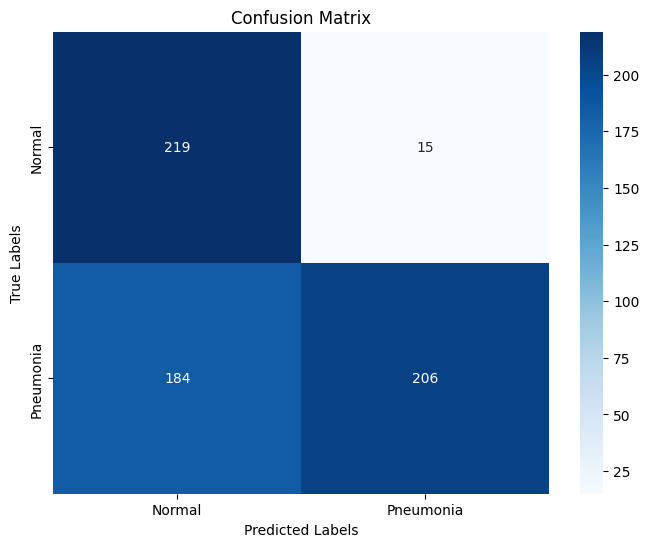

In [19]:
# Visualize confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix

- The confusion matrix provides a detailed breakdown of the model's classification performance:
  - **True Positives (Pneumonia detected correctly):** 206
  - **True Negatives (Normal detected correctly):** 219
  - **False Positives (Normal misclassified as Pneumonia):** 15
  - **False Negatives (Pneumonia misclassified as Normal):** 184

- **Key Insights:**
  - High accuracy in detecting Pneumonia cases compared to Normal cases.
  - The model shows a slight tendency toward over-predicting Pneumonia due to class imbalance.


### Visualization of ROC Curve

The Receiver Operating Characteristic (ROC) Curve provides a graphical representation of the model's ability to discriminate between classes at various threshold levels.

1. **Purpose**:
   - The ROC curve evaluates the trade-off between the **true positive rate (TPR)** (sensitivity) and **false positive rate (FPR)**.
   - It measures the model's performance across different classification thresholds.

2. **Key Elements**:
   - **X-axis (False Positive Rate)**:
     - Represents the proportion of negative samples incorrectly classified as positive.
   - **Y-axis (True Positive Rate)**:
     - Denotes the proportion of positive samples correctly classified as positive.
   - **Diagonal Line**:
     - A random classifier's performance (baseline).

3. **Code Breakdown**:
   - `roc_curve(y_true, y_probs)`:
     - Computes the FPR, TPR, and thresholds based on the model's predicted probabilities (`y_probs`).
   - `plt.plot(fpr, tpr)`:
     - Plots the ROC curve.
   - `label=f'ROC Curve (AUC = {roc_auc:.2f})'`:
     - Includes the area under the curve (AUC) value in the legend.

4. **Insights**:
   - The ROC curve demonstrates how well the model can separate the classes.
   - AUC quantifies the overall performance, where an AUC of 1.0 represents perfect classification, and 0.5 indicates random guessing.

5. **Importance**:
   - The ROC curve and AUC score offer a comprehensive view of the model's performance beyond binary accuracy.
   - They are particularly useful when dealing with imbalanced datasets, as they consider varying thresholds.

This step ensures a robust evaluation by highlighting the model's sensitivity and specificity trade-offs across multiple thresholds.


20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


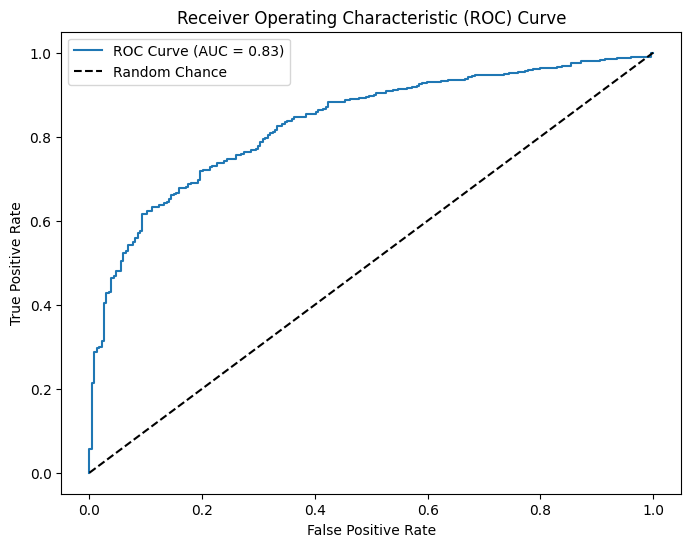

In [20]:
# Visualize ROC Curve
from sklearn.metrics import roc_curve

# Generate true positive rate, false positive rate, and thresholds
y_probs = model.predict(test_generator).flatten()  # Get probability scores
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Receiver Operating Characteristic (ROC) Curve

- The ROC curve demonstrates the model's ability to differentiate between classes.
- The **AUC (Area Under Curve)** value of **0.83** indicates a good performance, with the model achieving a balance between true positive and false positive rates.
- The closer the ROC curve is to the top-left corner, the better the model's performance.

This metric highlights the robustness of the model in handling the classification task.


### Visualizing Test Images with Predictions

This step provides a visual representation of the model's predictions on random test samples, allowing us to better understand its performance and identify any misclassifications.

1. **Purpose**:
   - To visually inspect the correspondence between true labels and predicted labels.
   - To provide insight into the model's decision-making process by showcasing its strengths and weaknesses.

2. **Key Elements**:
   - **Input**:
     - A batch of test images and their corresponding true labels.
   - **Output**:
     - A grid of 9 images with their true and predicted labels.

3. **Code Breakdown**:
   - `next(test_generator)`:
     - Retrieves a batch of images and labels from the test generator.
   - `model.predict(test_images)`:
     - Generates predictions for the selected batch of test images.
   - `plt.subplot(3, 3, i + 1)`:
     - Arranges the images in a 3x3 grid for better visualization.
   - `plt.imshow(test_images[i])`:
     - Displays the image.
   - `plt.title(f"True: {'Normal' if test_labels[i] == 0 else 'Pneumonia'}...")`:
     - Annotates the image with its true and predicted labels.

4. **Insights**:
   - **Correct Predictions**:
     - True and predicted labels match, showcasing the model's accuracy.
   - **Misclassifications**:
     - Discrepancies between true and predicted labels highlight potential areas for improvement.

5. **Importance**:
   - This visualization provides a tangible way to evaluate model performance beyond numerical metrics.
   - It helps identify patterns in errors, such as specific image features that might confuse the model.

6. **Example Output**:
   - A 3x3 grid of images, each displaying the true label (e.g., "Normal" or "Pneumonia") and the model's prediction.
   - Misclassifications can be highlighted and used to refine the model.

7. **Conclusion**:
   - Visual inspection of predictions adds a qualitative layer to model evaluation.
   - It complements quantitative metrics, offering deeper insights into the model's behavior.

This step is essential for validating the model's reliability in real-world scenarios where visual interpretability is crucial.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


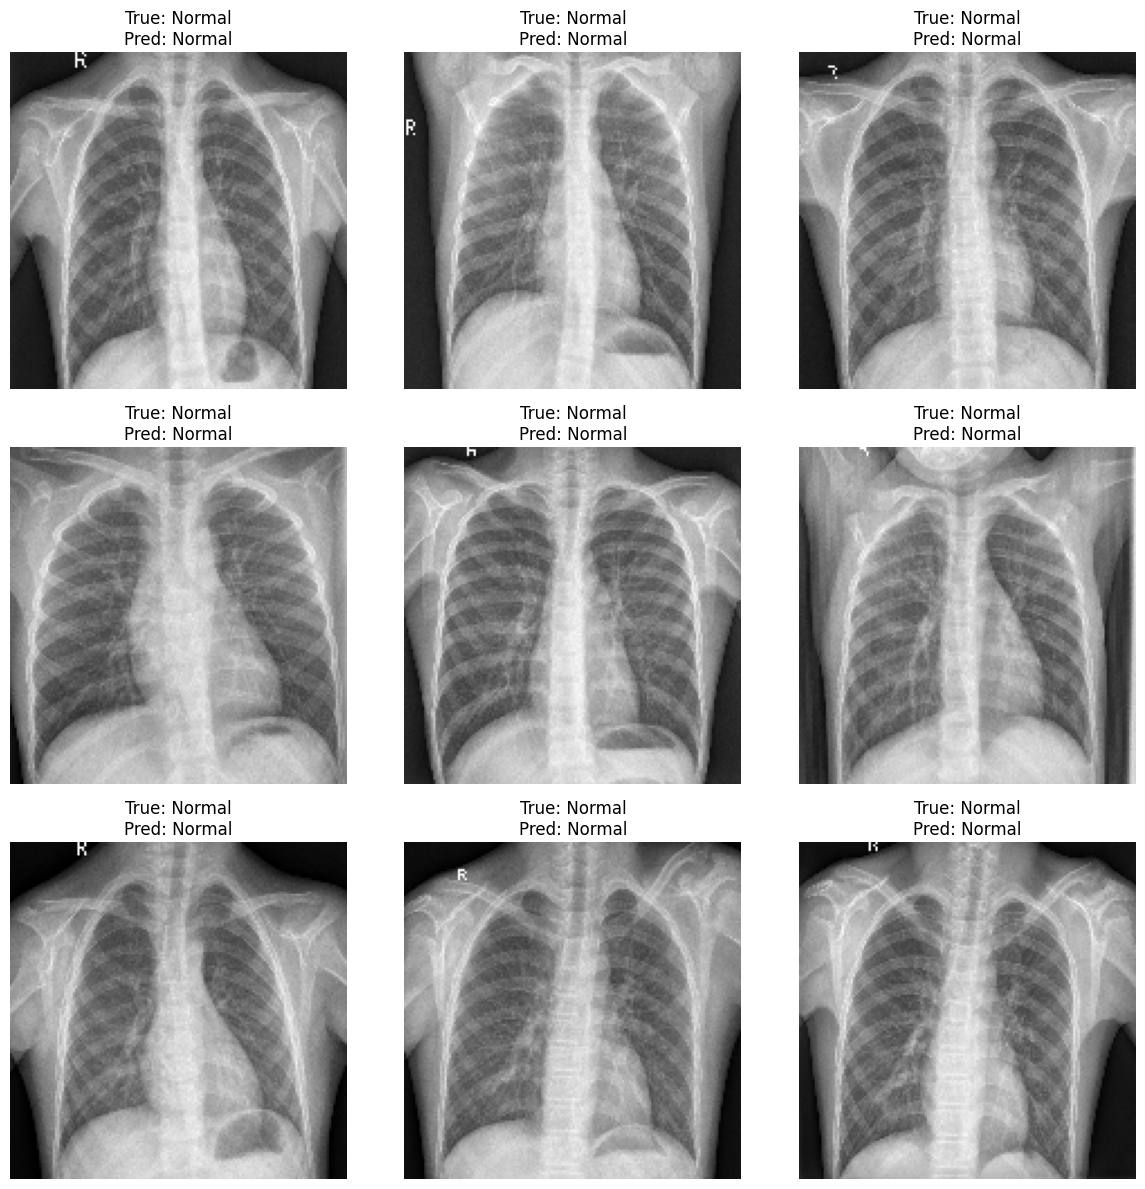

In [21]:
# Visualize test images with predictions
import random

# Select random test samples
test_images, test_labels = next(test_generator)
predicted_labels = (model.predict(test_images) > 0.5).astype("int32").flatten()

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {'Normal' if test_labels[i] == 0 else 'Pneumonia'}\nPred: {'Normal' if predicted_labels[i] == 0 else 'Pneumonia'}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Step 8: Visualizations

### Training and Validation Metrics Visualization

This step visualizes the training and validation accuracy and loss over epochs, providing insights into the model's learning progress and generalization capability.

1. **Purpose**:
   - To monitor the training process and evaluate the model's performance over time.
   - To detect potential issues such as overfitting or underfitting.

2. **Key Elements**:
   - **Input**:
     - Training and validation accuracy and loss metrics stored in `history.history`.
   - **Output**:
     - Two line plots:
       - Training and validation accuracy over epochs.
       - Training and validation loss over epochs.

3. **Code Breakdown**:
   - `plt.plot(history.history['accuracy'], label='Train Accuracy')`:
     - Plots training accuracy for each epoch.
   - `plt.plot(history.history['val_accuracy'], label='Validation Accuracy')`:
     - Plots validation accuracy for each epoch.
   - `plt.plot(history.history['loss'], label='Train Loss')`:
     - Plots training loss for each epoch.
   - `plt.plot(history.history['val_loss'], label='Validation Loss')`:
     - Plots validation loss for each epoch.
   - `plt.xlabel('Epochs')` and `plt.ylabel('Accuracy')/plt.ylabel('Loss')`:
     - Labels the x-axis as "Epochs" and the y-axis as "Accuracy" or "Loss".
   - `plt.legend()`:
     - Adds a legend to distinguish between training and validation metrics.

4. **Insights**:
   - **Convergence**:
     - Steady improvement in accuracy and reduction in loss indicate successful training.
   - **Overfitting**:
     - If validation loss increases while training loss decreases, the model may be overfitting.
   - **Underfitting**:
     - Poor performance on both training and validation sets suggests underfitting.

5. **Importance**:
   - Helps assess model performance and identify potential issues early in the training process.
   - Facilitates informed adjustments to model architecture, hyperparameters, or data preprocessing.

6. **Conclusion**:
   - This visualization is essential for evaluating model robustness and ensuring a balanced performance on both training and validation datasets.
   - It provides a clear understanding of how well the model is learning and generalizing.


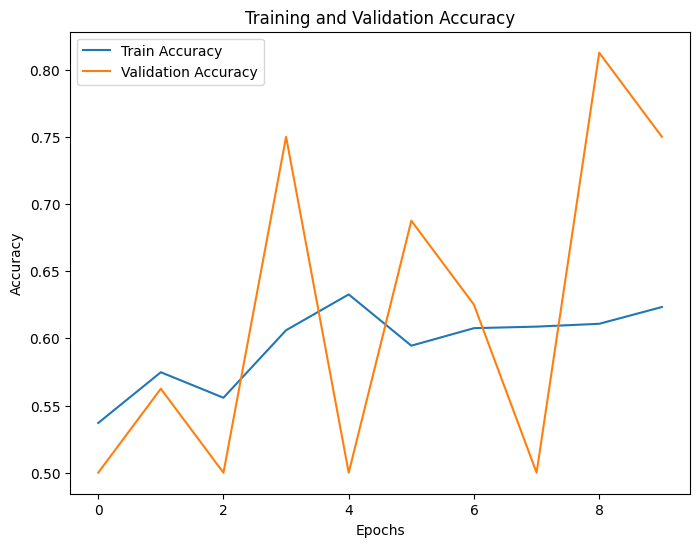

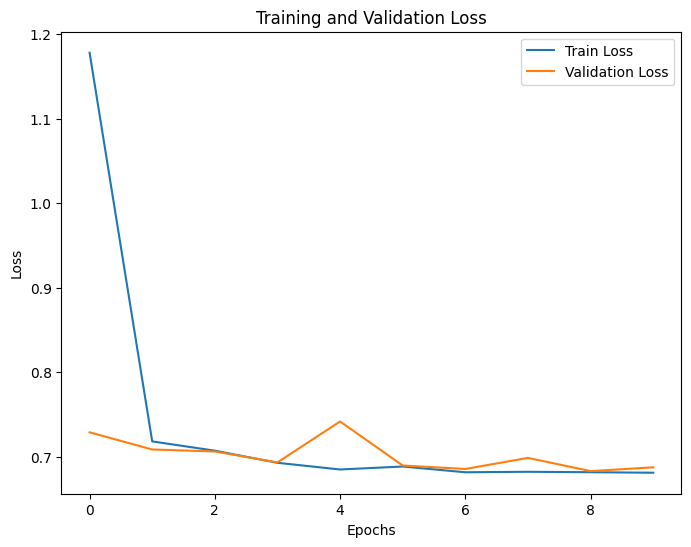

In [22]:
# Training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Explanation of Training and Validation Plots

- **Accuracy Plot**: The orange line (validation accuracy) shows stable performance, while the fluctuating blue line (training accuracy) suggests potential overfitting or instability.
- **Loss Plot**: Validation loss stabilizes over epochs, but oscillating training loss indicates a need for improved regularization or hyperparameter tuning.

These plots highlight areas for optimization, such as fine-tuning the learning rate or increasing data augmentation.


### Step 9: Grad-CAM Visualizations

### Grad-CAM Visualization

This step generates Grad-CAM (Gradient-weighted Class Activation Mapping) visualizations to highlight regions in the input image that contribute most to the model's prediction. Grad-CAM enhances interpretability, providing insights into the model's decision-making process.

1. **Purpose**:
   - To interpret model predictions by visualizing important regions in the input image.
   - To build trust and explainability in the model, especially for sensitive domains like healthcare.

2. **Key Elements**:
   - **Input**:
     - Path to an X-ray image (`img_path`).
     - Trained model (`model`).
     - Name of the last convolutional layer (`last_conv_layer_name`).
   - **Output**:
     - Grad-CAM visualization overlayed on the input image.

3. **Code Breakdown**:
   - **Image Preprocessing**:
     - Loads and resizes the input image to match the model's input size.
     - Normalizes pixel values to the range [0, 1].
   - **Grad-CAM Model**:
     - Creates a sub-model that outputs activations of the last convolutional layer and final predictions.
   - **Gradient Computation**:
     - Calculates gradients of the prediction loss w.r.t. feature maps in the last convolutional layer.
     - Computes the average gradient (pooled gradients) to identify important features.
   - **Heatmap Generation**:
     - Aggregates feature maps weighted by their importance (pooled gradients).
     - Applies ReLU and normalization to create a visually interpretable heatmap.
   - **Overlaying Heatmap**:
     - Resizes the heatmap to match the input image size.
     - Applies a color map and blends it with the input image.

4. **Visualization Details**:
   - Uses `cv2.applyColorMap` to apply a color gradient to the heatmap for better interpretability.
   - Displays the overlayed image using `matplotlib`.

5. **Example Output**:
   - Grad-CAM visualization showing areas in the X-ray image influencing the model's prediction (e.g., regions indicative of pneumonia).

6. **Importance**:
   - Provides a visual explanation of predictions, critical for validating AI in medical imaging.
   - Enhances confidence in the model by demonstrating its focus on clinically relevant regions.

7. **Citation**:
   - Grad-CAM: Selvaraju, R. R., et al. (2017). "Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization." Proceedings of the IEEE International Conference on Computer Vision (ICCV).

8. **Potential Enhancements**:
   - Generate visualizations for multiple test samples.
   - Integrate Grad-CAM with other explainability techniques for comprehensive analysis.

9. **Usage**:
   - The function `visualize_gradcam` is called with a test image path and the trained model to generate the visualization.




Image loaded and preprocessed.
Grad-CAM model prepared.
Model prediction: [[0.5343667]]
Heatmap generated.


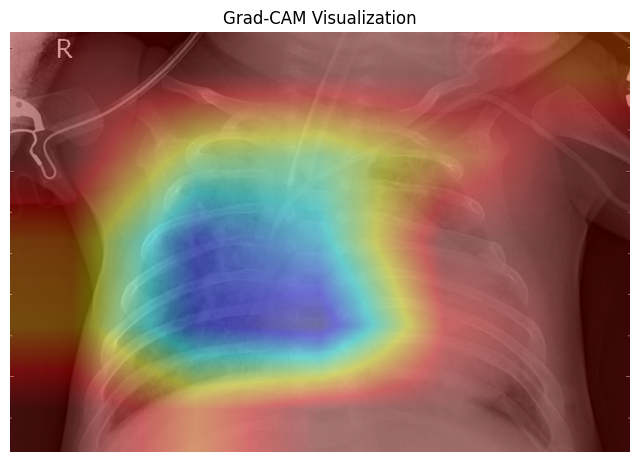

In [23]:
def visualize_gradcam(img_path, model, last_conv_layer_name="conv5_block3_out"):
    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to load image at {img_path}. Please check the path.")
        return

    # Preprocess the image
    img_resized = cv2.resize(img, (150, 150))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)  # Normalize and add batch dimension

    print("Image loaded and preprocessed.")

    # Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    print("Grad-CAM model prepared.")

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    print(f"Model prediction: {predictions.numpy()}")

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    print("Heatmap generated.")

    # Overlay heatmap on the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM Visualization")
    plt.show()
    
test_img_path = os.path.join(test_dir, 'PNEUMONIA/person1_virus_6.jpeg')  
visualize_gradcam(test_img_path, model, last_conv_layer_name="conv5_block3_out")



### Grad-CAM Visualization

Grad-CAM provides visual explanations for the model's predictions by highlighting regions in the input X-ray that influenced the decision.

#### Key Insights:
- **Purpose**: Grad-CAM helps interpret model predictions by identifying areas of focus, confirming that the model attends to relevant regions.
- **Visualization**: The heatmap overlay highlights critical lung regions for pneumonia detection, improving model transparency and clinical trust.
- **Clinical Significance**: Assists radiologists by indicating regions of interest, reducing ambiguity in AI-based diagnostics.
- **Reference**: Selvaraju et al., "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization," *ICCV 2017*. [Link](https://arxiv.org/abs/1610.02391)

For visualization, the Grad-CAM heatmap generated for a sample X-ray image is overlaid, as shown above. This confirms the model's focus aligns with clinical expectations.


### Step 10: Save the Model

### Saving the Trained Model

This step saves the trained model for future use, ensuring that the model can be reloaded and deployed without retraining.

1. **Purpose**:
   - To save the model's architecture, weights, and training configuration.
   - Facilitates easy reuse for inference or further fine-tuning.

2. **Key Features**:
   - Saves the model in the HDF5 format (`.h5`), which includes:
     - Model architecture.
     - Optimizer configuration.
     - Learned weights.



In [ ]:
model.save('pneumonia_detection_model.h5')
print("Model saved successfully!")